<a href="https://colab.research.google.com/github/Sabrish19/my-portfolio/blob/main/facedetection_Yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

[20250926-035034] ENTRY - Visitor ID: 3
[20250926-035034] ENTRY - Visitor ID: 2
Current Visitors (2): ['Visitor_3', 'Visitor_2']


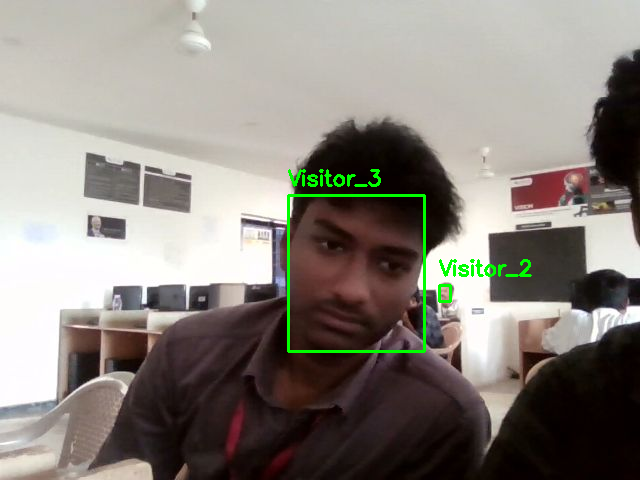

[20250926-035037] ENTRY - Visitor ID: 11
[20250926-035038] EXIT - Visitor ID: 3
Current Visitors (2): ['Visitor_2', 'Visitor_11']


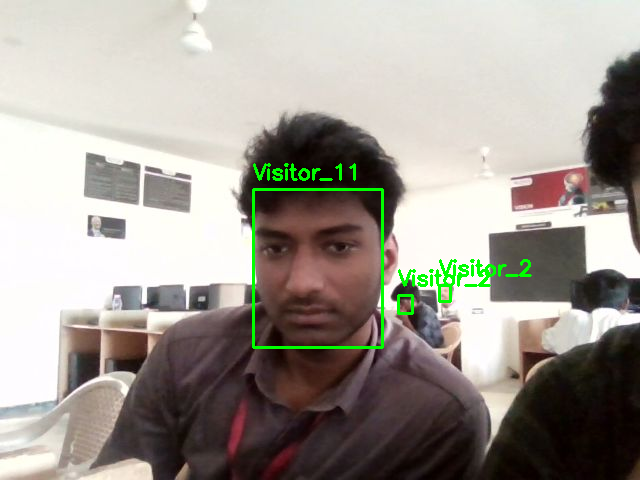

Current Visitors (2): ['Visitor_2', 'Visitor_11']


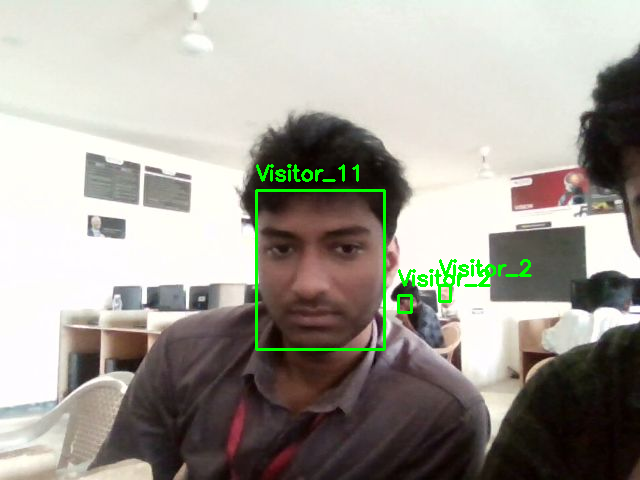

Current Visitors (2): ['Visitor_2', 'Visitor_11']


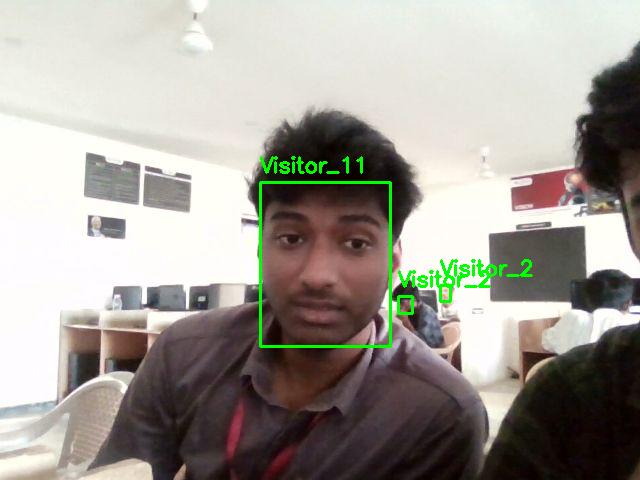

Current Visitors (2): ['Visitor_2', 'Visitor_11']


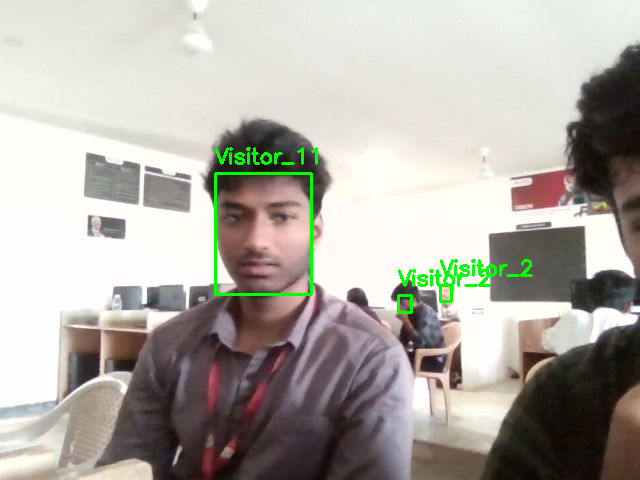

[20250926-035052] ENTRY - Visitor ID: 1
[20250926-035052] ENTRY - Visitor ID: 3
[20250926-035052] EXIT - Visitor ID: 2
[20250926-035052] EXIT - Visitor ID: 11
Current Visitors (2): ['Visitor_1', 'Visitor_3']


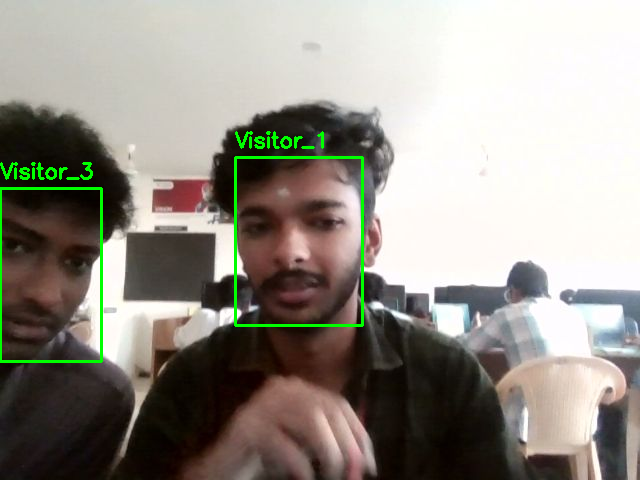

[20250926-035055] ENTRY - Visitor ID: 12
[20250926-035055] EXIT - Visitor ID: 3
Current Visitors (2): ['Visitor_1', 'Visitor_12']


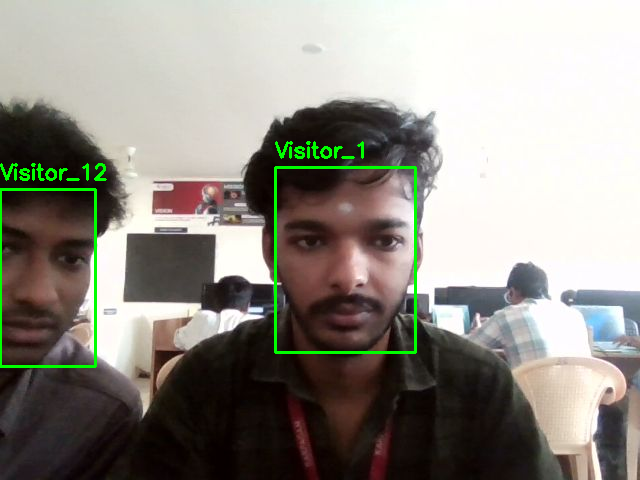

Current Visitors (2): ['Visitor_1', 'Visitor_12']


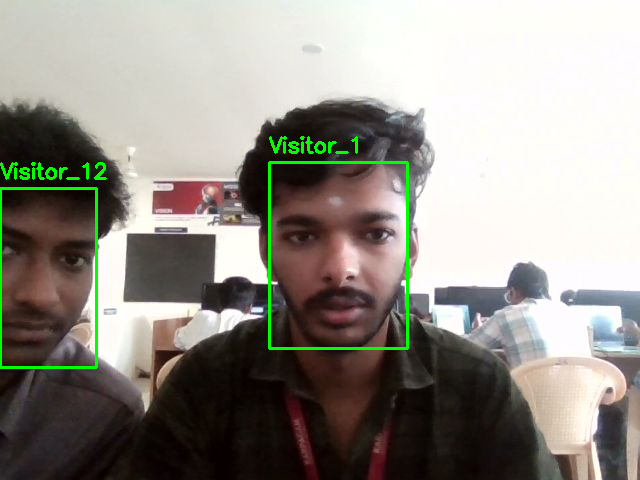

Current Visitors (2): ['Visitor_1', 'Visitor_12']


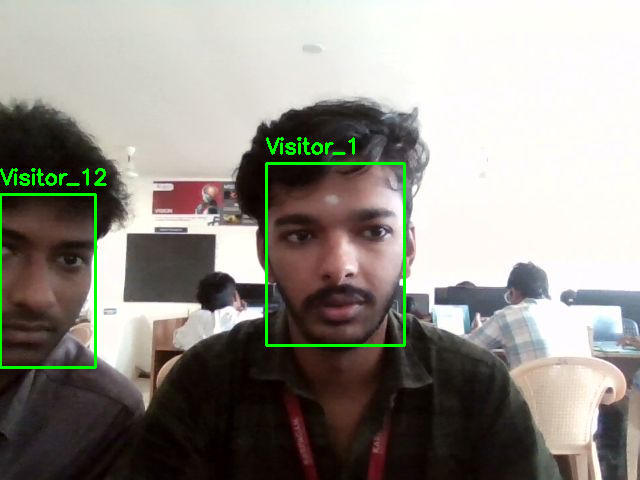

[20250926-035105] ENTRY - Visitor ID: 2
[20250926-035105] EXIT - Visitor ID: 12
Current Visitors (2): ['Visitor_1', 'Visitor_2']


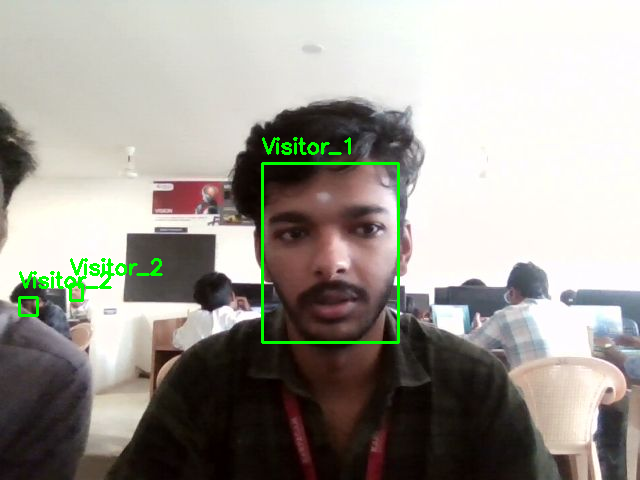

[20250926-035108] ENTRY - Visitor ID: 13
Current Visitors (3): ['Visitor_1', 'Visitor_2', 'Visitor_13']


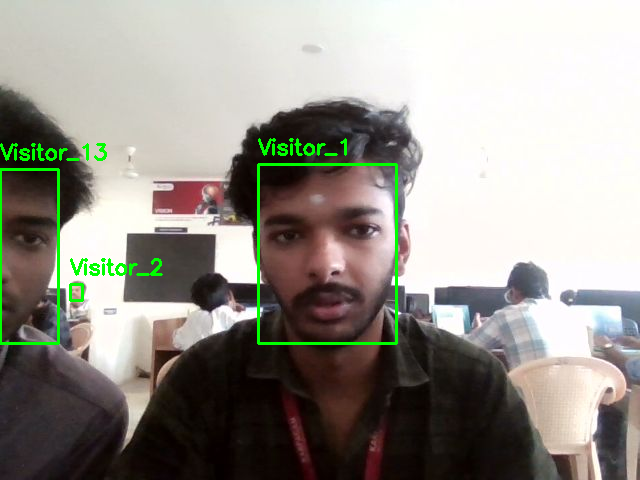

Current Visitors (3): ['Visitor_1', 'Visitor_2', 'Visitor_13']


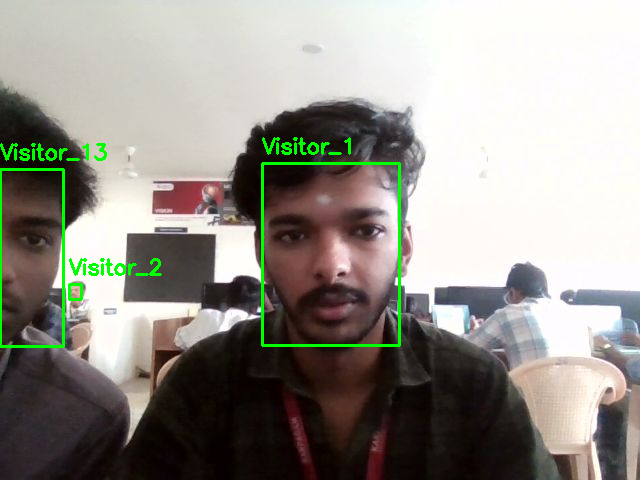

Current Visitors (3): ['Visitor_1', 'Visitor_2', 'Visitor_13']


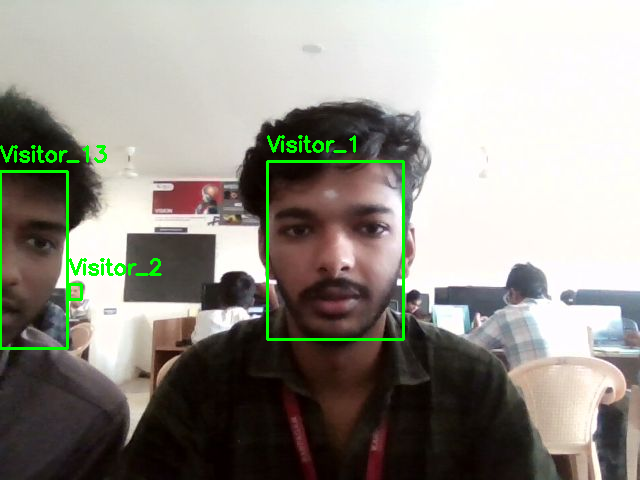

Current Visitors (3): ['Visitor_1', 'Visitor_2', 'Visitor_13']


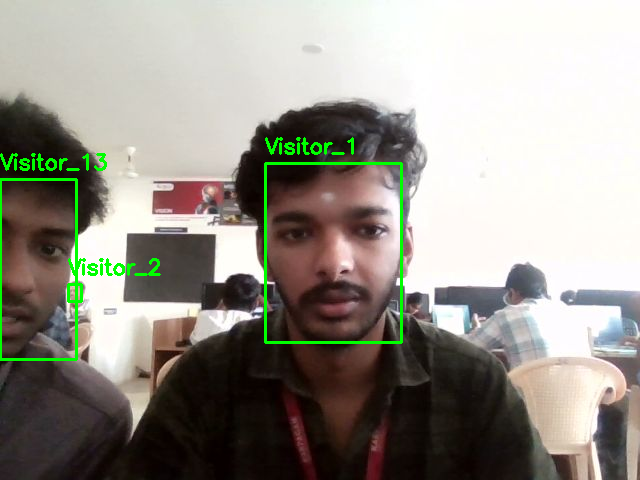

Current Visitors (3): ['Visitor_1', 'Visitor_2', 'Visitor_13']


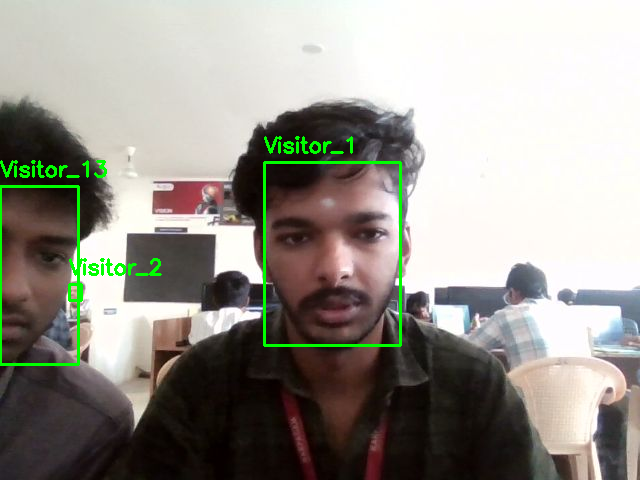

Current Visitors (3): ['Visitor_1', 'Visitor_2', 'Visitor_13']


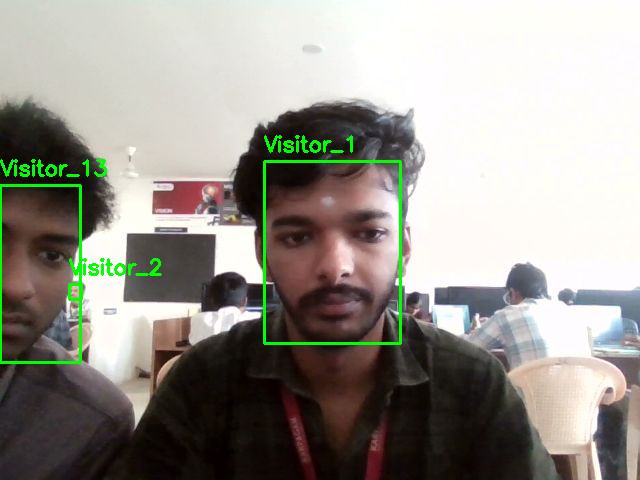

Current Visitors (3): ['Visitor_1', 'Visitor_2', 'Visitor_13']


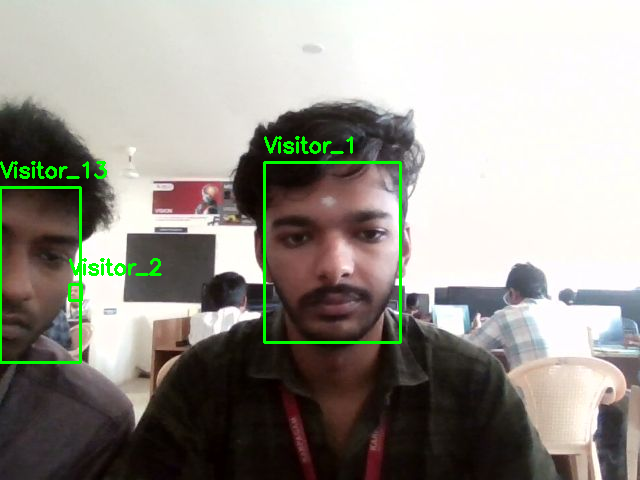

[20250926-035134] EXIT - Visitor ID: 2
Current Visitors (2): ['Visitor_1', 'Visitor_13']


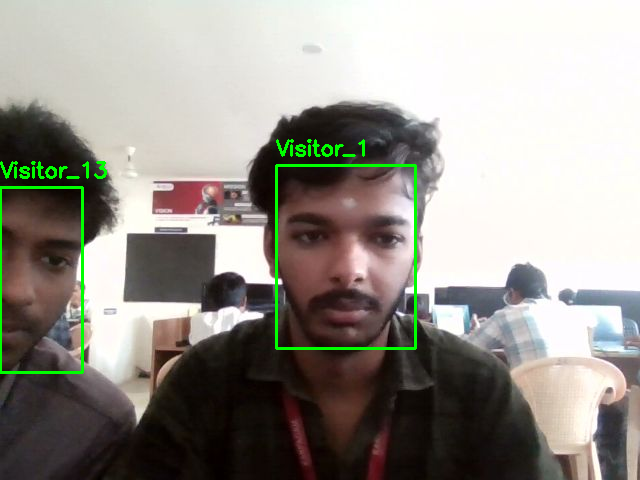

Stopped


In [7]:
# Install dependencies
!pip install ultralytics deepface opencv-python-headless --quiet

# Imports
import os, time, numpy as np, sqlite3
from deepface import DeepFace
from ultralytics import YOLO
from base64 import b64decode
from IPython.display import display, Javascript
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

# Mount Google Drive
drive.mount('/content/drive')

# Paths
DB_PATH = '/content/visitor_db.db'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/yolov8m_200e.pt'

# Database setup
conn = sqlite3.connect(DB_PATH)
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS visitors (
             id INTEGER PRIMARY KEY AUTOINCREMENT,
             name TEXT,
             embedding BLOB
             )''')
c.execute('''CREATE TABLE IF NOT EXISTS logs (
             id INTEGER PRIMARY KEY AUTOINCREMENT,
             visitor_id INTEGER,
             event TEXT,
             timestamp TEXT
             )''')
conn.commit()

# Load YOLO model
model = YOLO(MODEL_PATH)
THRESHOLD = 0.5

# Load known faces
known_faces = []
c.execute("SELECT id, name, embedding FROM visitors")
for vid, name, emb_blob in c.fetchall():
    emb = np.frombuffer(emb_blob, dtype=np.float32)
    known_faces.append({"id": vid, "name": name, "embedding": emb})

# Active tracking
active_faces = {}  # {visitor_id: {"last_seen": timestamp, "embedding": embedding, "name": name}}
COSINE_THRESHOLD = 0.75
EXIT_TIME = 3  # seconds to consider visitor exited

def cosine_similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def find_face(embedding):
    # First check active faces
    for vid, val in active_faces.items():
        if cosine_similarity(val["embedding"], embedding) > COSINE_THRESHOLD:
            return vid, val["name"]
    # Then check DB
    for face in known_faces:
        if cosine_similarity(face["embedding"], embedding) > COSINE_THRESHOLD:
            return face["id"], face["name"]
    return None, None

def register_face(name, embedding):
    c.execute("INSERT INTO visitors (name, embedding) VALUES (?,?)", (name, embedding.tobytes()))
    conn.commit()
    vid = c.lastrowid
    known_faces.append({"id": vid, "name": name, "embedding": embedding})
    return vid

def log_event(visitor_id, event):
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    c.execute("INSERT INTO logs (visitor_id, event, timestamp) VALUES (?,?,?)",
              (visitor_id, event, timestamp))
    conn.commit()
    print(f"[{timestamp}] {event.upper()} - Visitor ID: {visitor_id}")

def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    np_arr = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    return img

def detect_recognize(frame):
    global active_faces
    current_ids = []

    results = model.predict(frame, verbose=False)

    for result in results:
        for box, score in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.conf.cpu().numpy()):
            if score < THRESHOLD:
                continue
            x1, y1, x2, y2 = map(int, box)
            face_crop = frame[y1:y2, x1:x2]

            try:
                emb = np.array(DeepFace.represent(face_crop, model_name='Facenet', enforce_detection=False)[0]["embedding"], dtype=np.float32)
            except:
                continue

            visitor_id, name = find_face(emb)

            if visitor_id in active_faces:
                # Already active, update timestamp
                active_faces[visitor_id]["last_seen"] = time.time()
            elif visitor_id is None:
                # New visitor
                name = f"Visitor_{len(known_faces)+1}"
                visitor_id = register_face(name, emb)
                log_event(visitor_id, "entry")
                active_faces[visitor_id] = {"last_seen": time.time(), "embedding": emb, "name": name}
            else:
                # Known but not active
                log_event(visitor_id, "entry")
                active_faces[visitor_id] = {"last_seen": time.time(), "embedding": emb, "name": name}

            current_ids.append(visitor_id)

            # Draw green rectangle and visitor name
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, f"{name}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Remove exited faces
    exited = [vid for vid, val in active_faces.items() if vid not in current_ids and time.time() - val["last_seen"] > EXIT_TIME]
    for vid in exited:
        log_event(vid, "exit")
        del active_faces[vid]

    # Print active visitor count and IDs
    visitor_list = [val["name"] for val in active_faces.values()]
    print(f"Current Visitors ({len(visitor_list)}): {visitor_list}")

    # Show frame inline in Colab
    cv2_imshow(frame)

# Start webcam in Colab
def video_stream():
    js = Javascript('''
        async function startVideo() {
            window.videoReady = false;
            const video = document.createElement('video');
            video.width = 640; video.height = 480;
            video.autoplay = true;
            const stream = await navigator.mediaDevices.getUserMedia({video:true});
            video.srcObject = stream;
            document.body.appendChild(video);

            const canvas = document.createElement('canvas');
            canvas.width = 640; canvas.height = 480;
            document.body.appendChild(canvas);
            const ctx = canvas.getContext('2d');

            window.captureFrame = () => {
                ctx.drawImage(video, 0, 0, 640, 480);
                return canvas.toDataURL('image/jpeg', 0.8);
            }
            window.videoReady = true;
        }
        startVideo();
    ''')
    display(js)

# Run recognition
video_stream()
from google.colab.output import eval_js
import time

time.sleep(3)  # wait for JS video

try:
    while True:
        js_reply = eval_js("window.captureFrame()")
        if not js_reply:
            continue
        frame = js_to_image(js_reply)
        detect_recognize(frame)  # Logs + green boxes + visitor count
        time.sleep(0.5)
except KeyboardInterrupt:
    print("Stopped")


In [9]:
from getpass import getpass

# This will prompt you to enter the token securely
GITHUB_TOKEN = getpass("Enter your Token")

Enter your Token··········


In [17]:
%cd /content/face_detection-Yolov8

/content/face_detection-Yolov8


In [19]:
!ls
!git init
BRANCH_NAME = "colab-version"
!git checkout -b {BRANCH_NAME}


Reinitialized existing Git repository in /content/face_detection-Yolov8/.git/
Switched to a new branch 'colab-version'


In [21]:
!git config --global user.name "Sabrish19"
!git config --global user.email "sabrishdevan948@gmail.com"


In [20]:
!git add .
!git commit -m "Initial push of face detection Colab code"


Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@e61db8890715.(none)')


In [29]:
# Save a copy of the current notebook to /content
!jupyter nbconvert --to notebook --output facedetection_Yolov8.ipynb /content/face_detection-Yolov8.ipynb


[NbConvertApp] WARNING | pattern '/content/face_detection-Yolov8.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=

In [36]:
!mv /content/face_detection_Yolov8.ipynb /content/face_detection-Yolov8/



mv: cannot stat '/content/face_detection_Yolov8.ipynb': No such file or directory
